In [18]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, LinearRegression

In [38]:
final_test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

X = train.drop(columns=['price'])
y = train['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=307)

Text(0.5, 1.0, 'Heatmap of the Numeric Columns')

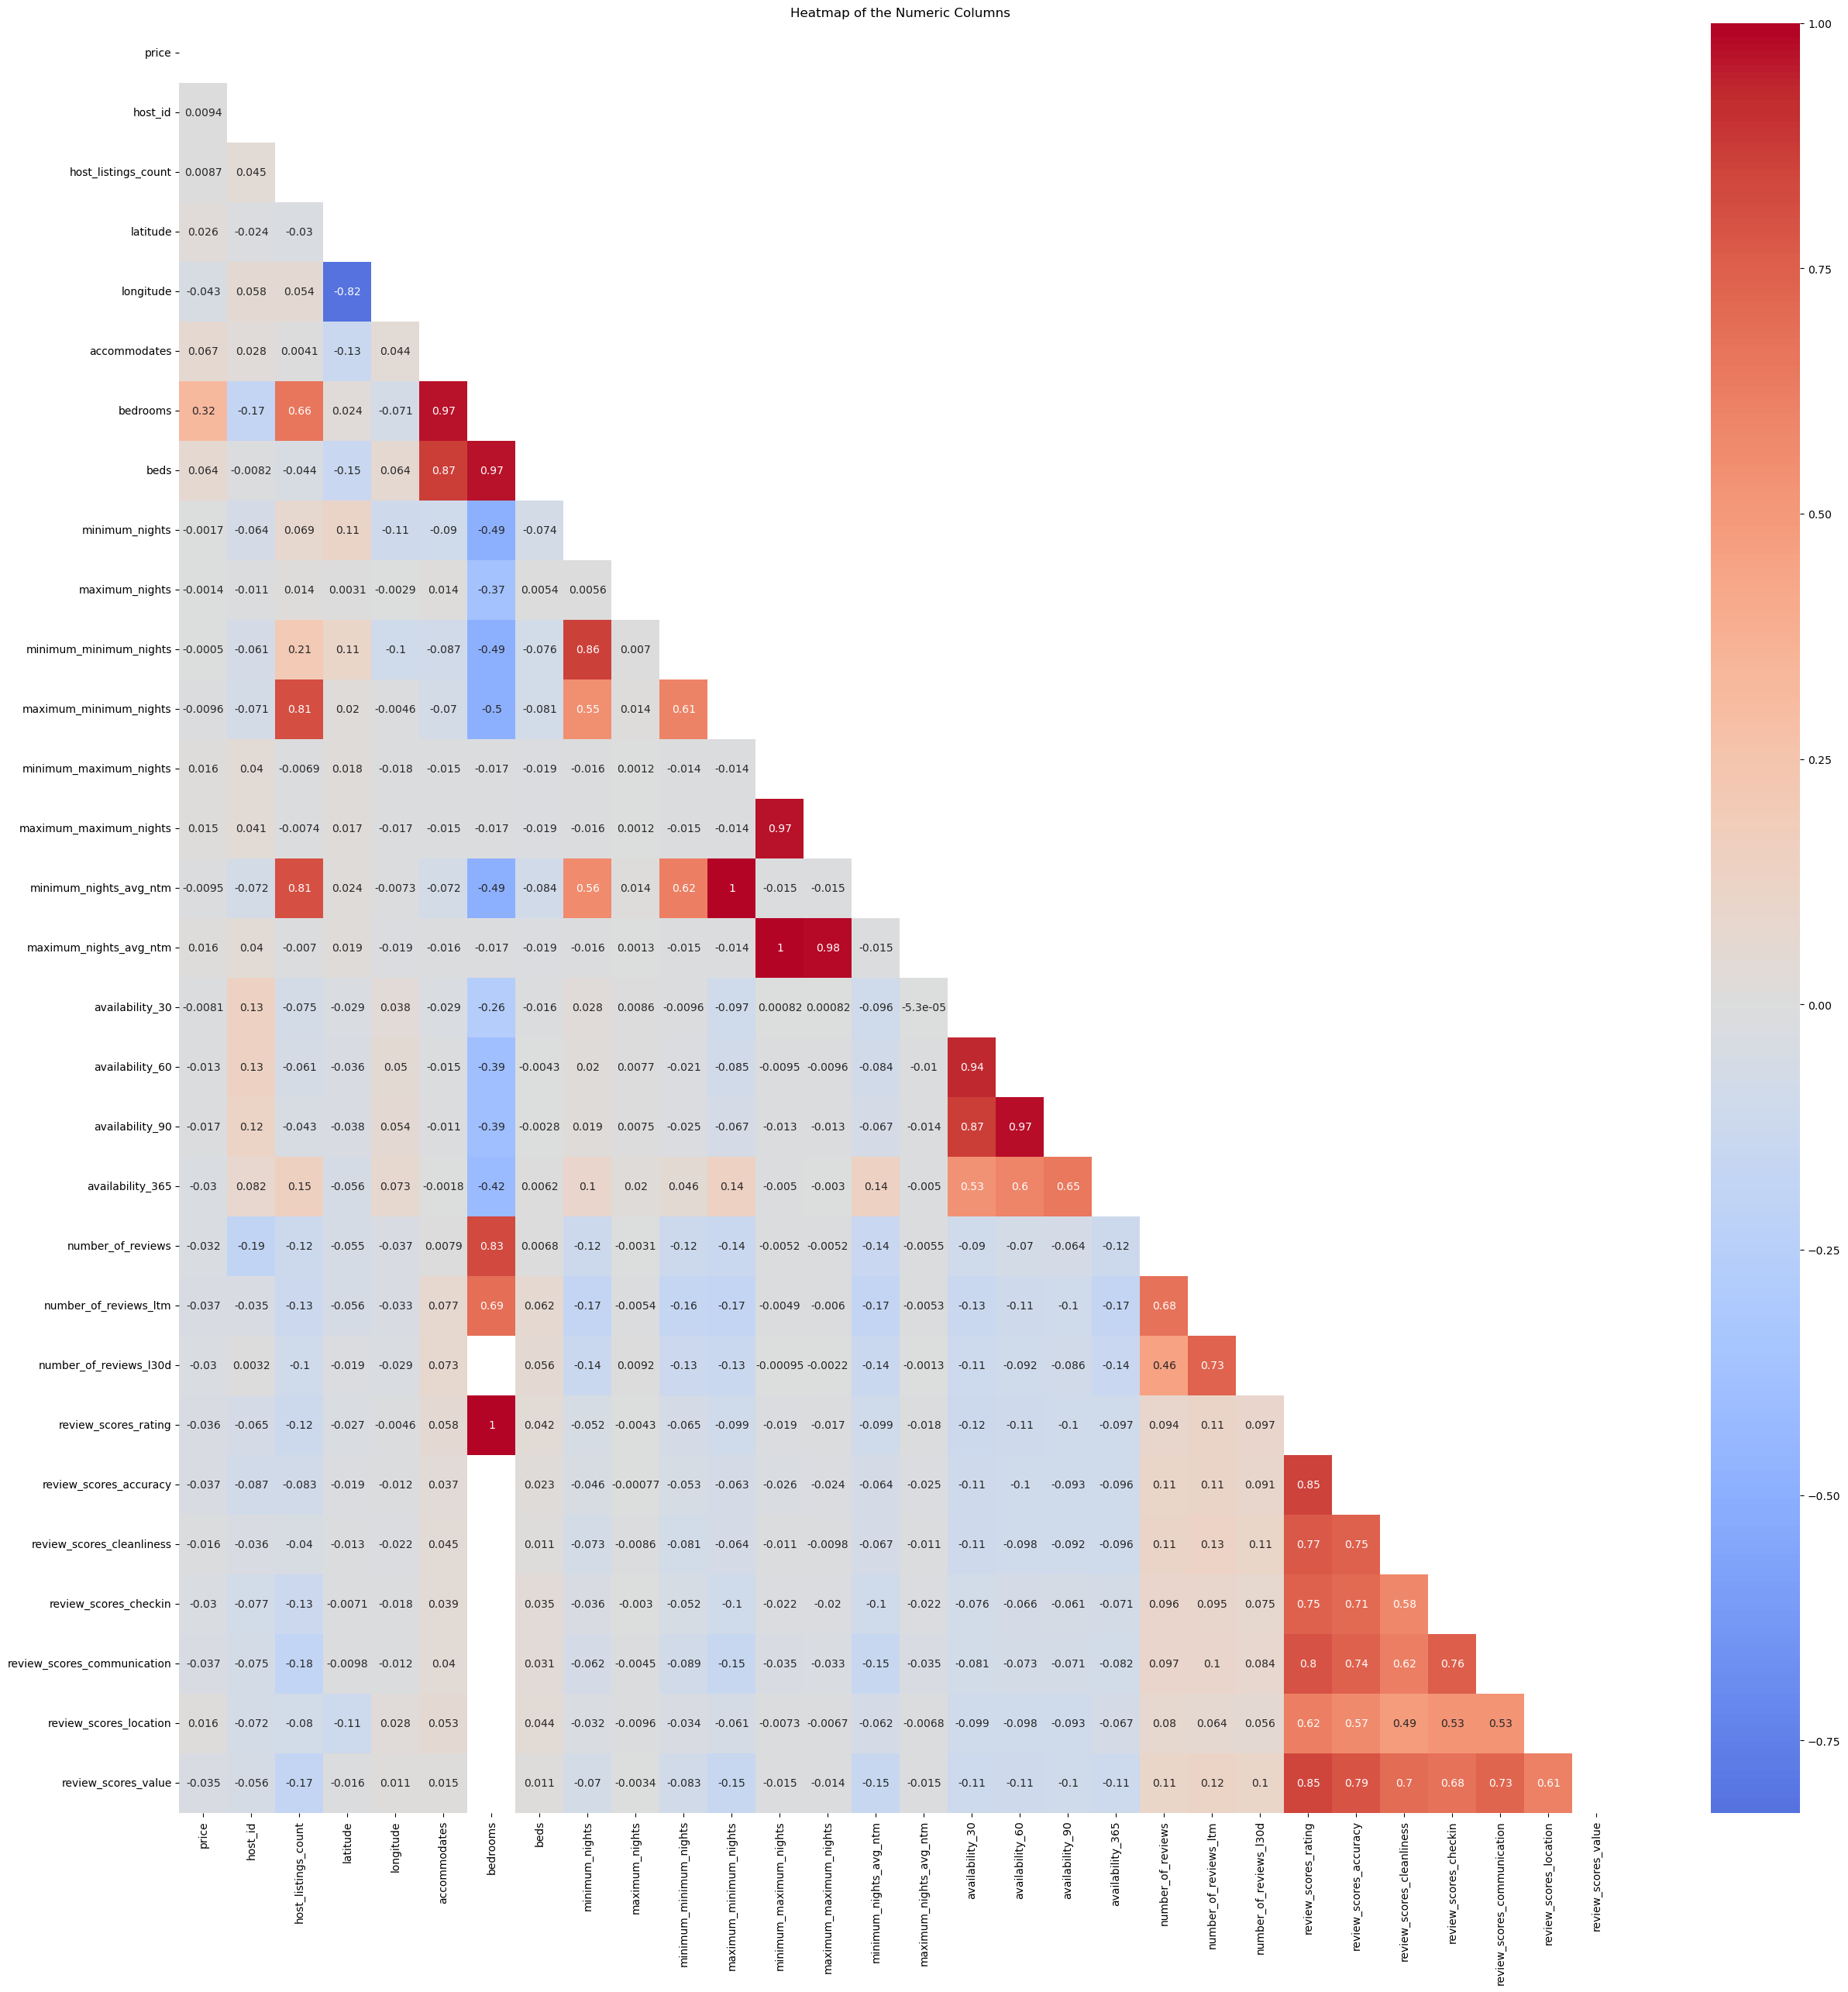

In [10]:
# EDA graphs on the training data
import seaborn as sns
import matplotlib.pyplot as plt
# Heatmap of the numeric columns
numeric = train.select_dtypes(include='number')
plt.figure(figsize=(30, 30))
corr = numeric.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, annot=True)
plt.title('Heatmap of the Numeric Columns')


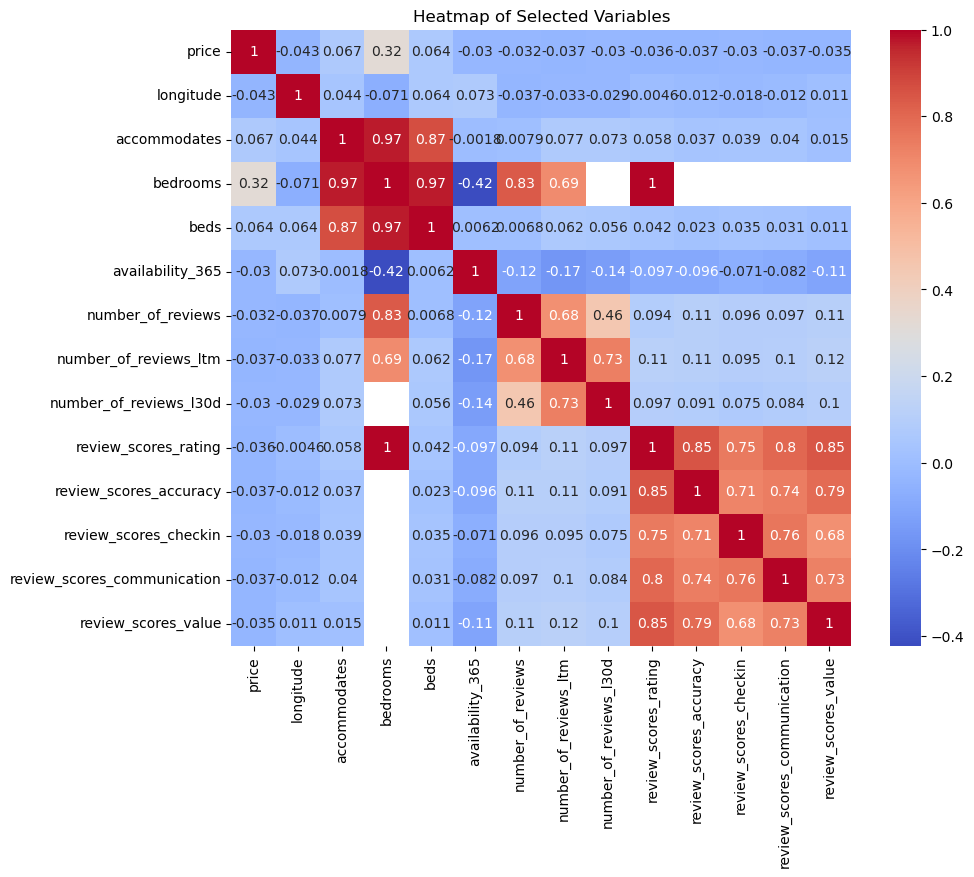

In [15]:
# Calculate the correlation matrix
correlation_matrix = numeric.corr()

# Select the variables with correlation >= 0.3 with 'price'
selected_variables = correlation_matrix[abs(correlation_matrix['price']) >= 0.03].index

# Filter the DataFrame to include only the selected variables
selected_df = train[selected_variables]

# Create a heatmap of the selected variables
plt.figure(figsize=(10, 8))
sns.heatmap(selected_df.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Selected Variables')
plt.show()


In [23]:
from scipy.stats import chi2_contingency
categorical_variables = train.select_dtypes(include='object').columns.tolist()
print(categorical_variables)
# Calculate the Cramér's V statistic for each categorical variable
correlation_matrix = pd.DataFrame(index=categorical_variables, columns=['Cramér\'s V'])

for var in categorical_variables:
    contingency_table = pd.crosstab(train[var], train['price'])
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    correlation_matrix.loc[var, 'Cramér\'s V'] = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Print the correlations that are above 0.15
high_corr_cats = correlation_matrix[correlation_matrix['Cramér\'s V'] > 0.15]
print(high_corr_cats)


['Id', 'name', 'neighborhood_overview', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'amenities', 'has_availability', 'first_review', 'last_review', 'instant_bookable']


C:\Users\hermi\AppData\Local\Temp\ipykernel_17912\3085270330.py:16: RuntimeWarning: invalid value encountered in scalar divide
  correlation_matrix.loc[var, 'Cramér\'s V'] = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


                      Cramér's V
name                    0.371569
neighborhood_overview    0.23213
host_location           0.156906
host_acceptance_rate    0.163547
host_is_superhost       0.171513
host_has_profile_pic    0.168065
room_type               0.490061
bathrooms_text          0.466489
instant_bookable        0.243065


In [33]:
# Define the pipeline
cat_pipe = Pipeline([
  ('impute', SimpleImputer(strategy='most_frequent')),
  ('one_hot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
  ('select', SelectPercentile(f_regression, percentile=50))
])
num_pipe = Pipeline([
  ('impute', SimpleImputer(strategy='mean')),
  ('poly', PolynomialFeatures(degree=2, include_bias=False)),
  ('standardize', StandardScaler())
])
preprocessing = ColumnTransformer(
  transformers=[
    ('cat', cat_pipe, ['name', 
                       'neighborhood_overview',
                       'host_location',
                       'host_acceptance_rate',
                       'host_is_superhost',
                       'host_has_profile_pic',
                       'room_type',
                       'bathrooms_text',
                       'instant_bookable']),  
    ('num', num_pipe, ['longitude', 
                      'accommodates',
                      'bedrooms',
                      'beds',
                      'availability_365',
                      'number_of_reviews',
                      'number_of_reviews_ltm',
                      'number_of_reviews_l30d',
                      'review_scores_rating',
                      'review_scores_accuracy',
                      'review_scores_checkin',
                      'review_scores_communication',
                      'review_scores_value']) 
  ])

pipe_full = Pipeline([
  ('preprocessing', preprocessing),
  ('model', KNeighborsRegressor(n_neighbors=20, weights='distance'))
])


Mean Squared Error: 2604043.8483828623


In [34]:
pipe_full.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('select',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function f_regression at 0x0000019EF1255480>))]),
                                                  ['name',
                                                   'neighborhood_overview',
                                                   'host_loc...
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['longitude', 'accommodates',
                                                   'bedrooms', 'beds',
                                                   'availability_365',
                                                   'number_of_reviews',
                                                   'number_of_reviews_ltm',
                                                   'number_of_reviews_l30d',
                                                   'review_scores_rating',
                                                   'review_scores_accuracy',
                                                   'review_scores_checkin',
                                                   'review_scores_communication',
                                                   'review_scores_value'])])),
                ('model',
                 KNeighborsRegressor(n_neighbors=20, weights='distance'))])

In [35]:
y_train_pred = pipe_full.predict(X_train)
training_mse = mean_squared_error(y_train, y_train_pred)
yhat = pipe_full.predict(X_test)
test_mse = mean_squared_error(y_test, yhat)
print("Training MSE:", training_mse)
print("Test MSE:", test_mse)

Training MSE: 18652.191107056606
Test MSE: 1026781.8711489774


In [42]:
# Predict for the final test data including the Id column
final_test['price'] = pipe_full.predict(final_test)
final_test[['Id', 'price']].to_csv('submission.csv', index=False)